In [1]:
# import package

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim.lr_scheduler import StepLR

# dataset and transformation
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from skimage import io, transform

# display images
from torchvision import utils
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

# utils
import numpy as np
from torchsummary import summary
import time
import copy
import random


from PIL import Image
import torch
from torch.utils.data import Dataset

# !pip install efficientnet_pytorch
import torchvision.models as models
from tqdm import tqdm

import warnings
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import train_test_split

In [2]:
import logging

def get_logger(file_path):
    logger = logging.getLogger()
    log_format = '%(asctime)s | %(message)s'
    formatter = logging.Formatter(log_format, datefmt='%m/%d %I:%M:%S %p')
    file_handler = logging.FileHandler(file_path)
    file_handler.setFormatter(formatter)
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)

    logger.addHandler(file_handler)
    logger.addHandler(stream_handler)
    logger.setLevel(logging.INFO)

    return logger

log_name = '{}'.format(time.strftime("%m%d-%H%M"))
log_path = './log'+'/'+log_name
if not os.path.isdir('log'):
    os.mkdir('log')
if not os.path.isdir(log_path):
    os.mkdir(log_path)
logger = get_logger(os.path.join(log_path, "{}.log".format(log_name)))

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
seed = 777

def make_reproducible(seed=0):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
make_reproducible(seed)

In [5]:
import pandas as pd
path2csv = './t_result.csv'
df = pd.read_csv(path2csv)
dir_list = []
for i in range(len(df)):
    dir_list.append('./data_front/'+df['fname'][i])
df.drop(['angle'], axis=1, inplace=True)
#df.drop(['a','v'], axis=1, inplace=True)
df.tail(3)

,fname,labels
3997,BH897front.jpg,1
3998,BH898front.jpg,1
3999,BH899front.jpg,1


In [6]:
class frontDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        
        self.metadata = dataframe
        self.root_dir = './data_front/'
        self.transform = transform

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = self.root_dir + self.metadata.iloc[idx, 0]
        image = Image.open(img_name)
        label = self.metadata.iloc[idx,1:]
        label = np.array([label])
        label = label.astype('float').reshape(-1)
        
        #sample = {'image': image, 'feature': feature}
        
        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [7]:
ratio = 0.1

train, test = train_test_split(df, test_size = ratio, random_state = seed)
print("train : ", len(train))
print("test : ", len(test))

train :  3600
test :  400


In [8]:
im_size = 224
train_dataset = frontDataset(train,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                                transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

test_dataset = frontDataset(test,transform=transforms.Compose([
                                               transforms.Resize(im_size),
                                               transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
                                           ]))

In [9]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(train_dataset,
                                             batch_size=batch_size, 
                                             shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                             batch_size=batch_size, 
                                             shuffle=False)

08/16 01:22:45 AM | Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


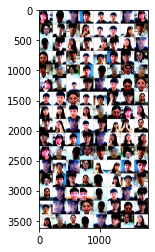

tensor([[0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
      

In [10]:
def imshow(img):
    img = img / 2 + 0.5 #unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()

dataiter = iter(train_loader)

images, features = dataiter.next()

imshow(torchvision.utils.make_grid(images))

print(features)

In [11]:
model = models.shufflenet_v2_x1_0(pretrained=True)
#model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=1)
num_ftrs = model.fc.in_features # fc의 입력 노드 수를 산출한다. 1000개
model.fc = nn.Linear(num_ftrs, 1) # fc를 nn.Linear(num_ftrs, 1)로 대체한다.

model = model.to(device)

In [12]:
print(model)

ShuffleNetV2(
  (conv1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stage2): Sequential(
    (0): InvertedResidual(
      (branch1): Sequential(
        (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=24, bias=False)
        (1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (3): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): ReLU(inplace=True)
      )
      (branch2): Sequential(
        (0): Conv2d(24, 58, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(58, eps=1e-05, momentum=0.1, affine=True, track_running_

In [13]:
num_epochs = 50
learning_rate = 0.001
loss_func = torch.nn.BCELoss()
opt = optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
scheduler = optim.lr_scheduler.LambdaLR(optimizer=opt,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,)

In [15]:
def train(model, train_loader, optimizer, logger):
#    for epoch in range(num_epochs):
    running_loss = 0.0
    running_corrects = 0
    run_cnt = 0
#    for data in tqdm(train_loader):
    for i, data in enumerate(train_loader):
        inputs, gt = data
        inputs, gt = inputs.to(device), gt.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = torch.sigmoid(outputs)
        
        loss = loss_func(outputs.double(), gt.double()).float()
        
        loss.backward()
        optimizer.step()
        
        outputs = ((outputs)-0.5>0).float().detach() #0.5 이하 0 
        
        running_loss += loss.item()
        running_corrects += torch.sum(outputs.int() == gt.data.int()).float()
        run_cnt += len(gt)
        
        #print('-'*30)
        
        #print('running_correct ', running_corrects)
        #print('run_cnt ', run_cnt)
    
        #print('current batch: %d / %d'%(n, len(train_loader)))
    cost = running_loss / len(train_loader)
    acc = (running_corrects.double() / run_cnt)*100
    train_loss_list.append(cost)
    train_acc_list.append(acc)
    
    logger.info('train loss: %.4f, train acc: %.4f' %(cost, acc))

    #print('train loss: %.4f, train train: %.4f' %(cost, acc)) 

In [16]:
def test(model, test_loader, opt, logger):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    run_cnt = 0
    with torch.no_grad():
        for data in test_loader:
            inputs, gt = data
            inputs, gt = inputs.to(device), gt.to(device)

            outputs = model(inputs)
            outputs = torch.sigmoid(outputs)

            loss = loss_func(outputs.double(), gt.double()).float()

            outputs = ((outputs)-0.5>0).float().detach() #0.5 이하 0 

            running_loss += loss.item()
            running_corrects += torch.sum(outputs.int() == gt.data.int()).float()
            run_cnt += len(gt)
            #print('current batch: %d / %d'%(n, len(train_loader)))
        cost = running_loss / len(test_loader)
        acc = (running_corrects.double() / run_cnt)*100
        test_loss_list.append(cost)
        test_acc_list.append(acc)
        #print("correct : ", correct)
        #print(total)
        logger.info('test loss: %.4f, test acc : %.4f' %(cost, acc))
        
        #print('test loss: %.4f, test acc : %.4f' %(cost, acc)) 

In [17]:
logger.info("data split ratio : %.2f"%ratio)
logger.info("batch size : %d"%batch_size)
logger.info("image size : %d"%im_size)
logger.info("optimizer : %s"%str(opt))
logger.info("learning rate : %s"%str(learning_rate))

08/16 01:22:51 AM | data split ratio : 0.10
08/16 01:22:51 AM | batch size : 128
08/16 01:22:51 AM | image size : 224
08/16 01:22:51 AM | optimizer : Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    initial_lr: 0.001
    lr: 0.001
    weight_decay: 0
)
08/16 01:22:51 AM | learning rate : 0.001


In [ ]:
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

for i in range(num_epochs):
    logger.info("==================== EPOCH :  %d ===================="%i)
    #print('='*20,'EPOCH : ', i,'='*20)
    #print('-'*20,'TRAIN','-'*20)
    train(model, train_loader, opt, logger)
    #print('-'*20,'TEST','-'*20)
    test(model, test_loader, opt, logger)
    scheduler.step()

08/16 01:22:51 AM | ==================== EPOCH :  0 ====================
08/16 01:23:15 AM | train loss: 0.4847, train acc: 81.8056
08/16 01:23:17 AM | test loss: 0.4535, test acc : 81.5000
08/16 01:23:17 AM | ==================== EPOCH :  1 ====================
08/16 01:23:39 AM | train loss: 0.4834, train acc: 79.0833
08/16 01:23:41 AM | test loss: 0.5049, test acc : 75.0000
08/16 01:23:41 AM | ==================== EPOCH :  2 ====================
08/16 01:24:05 AM | train loss: 0.3056, train acc: 86.4444
08/16 01:24:07 AM | test loss: 0.3573, test acc : 85.2500
08/16 01:24:07 AM | ==================== EPOCH :  3 ====================
08/16 01:24:30 AM | train loss: 0.2560, train acc: 88.8611
08/16 01:24:32 AM | test loss: 0.4257, test acc : 82.7500
08/16 01:24:32 AM | ==================== EPOCH :  4 ====================
08/16 01:24:58 AM | train loss: 0.2438, train acc: 89.1389
08/16 01:25:00 AM | test loss: 0.3821, test acc : 84.5000
08/16 01:25:00 AM | ==================== EPOCH :  

In [ ]:
plt.plot(train_acc_list, 'r', label = 'train_acc')
plt.plot(test_acc_list, 'g', label = 'test_acc')
plt.title('ACC')
plt.legend()
plt.show()

In [ ]:
plt.plot(train_loss_list, 'r', label = 'train_loss')
plt.plot(test_loss_list, 'g', label = 'test_loss')
plt.title('LOSS')
plt.legend()
plt.show()